In [1]:
import pandas as pd, numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import matplotlib 
import matplotlib.pyplot as plt
from sklearn import metrics
matplotlib.rcParams['figure.figsize'] = (30,30) 

## Helper Functions

In [2]:
def get_scores(y_true, y_pred):
    """
    This function returns various scoring metrics for our models.
    """
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))

In [3]:
def get_total_in_range(df, feature, lat_bins, long_bins, average=False):
    """
    This function sums or averages the given values inside geographically-bounded boxes.
    We create evenly spaced bins of latitude and longitude and then loop over the bins and find
    the subset of the dataframe which has properties inside the bounding box. We then perform
    an operation on these properties and return the final grid.
    """
    result = []
    for i in range(len(long_bins)-1):
        inner=[]
        for j in range(len(lat_bins)-1):
            if average:
                mean=np.mean(df[(df.lat_centroid>lat_bins[i]) & (df.lat_centroid<lat_bins[i+1]) &
                                (df.long_centroid>long_bins[j]) & (df.long_centroid<long_bins[j+1])][feature])
                if mean!=mean:
                    mean=0
                inner.append(mean)
            else:
                inner.append(sum(df[(df.lat_centroid>lat_bins[i]) & (df.lat_centroid<lat_bins[i+1]) &
                                (df.long_centroid>long_bins[j]) & (df.long_centroid<long_bins[j+1])][feature]))
        result.append(inner)
    return result

## Prepare Data

In [4]:
data=pd.read_csv('land_listings_June.csv')
data=data.drop(data.columns[0],axis=1)
data['ppa']=data['price']/data['acres']
data=data[data.ppa<200000]    # We want to avoid any outliers that may be typos
def check_improved(row):
    """
    We have incomplete data for the assessed value of the improvements because this data
    is not available in all counties. However, we scrape the number of beds and baths
    on each property. We consider a property signficiantly improved if more than 15% of the
    value comes for improvements or if it has a house.
    """
    if row.baths>0 or row.improvval / row.price > 0.15:
        return 1
    return 0
data['improved']=data.apply(lambda x: check_improved(x),axis=1)

## Data Exploration

### Map of Listing Count

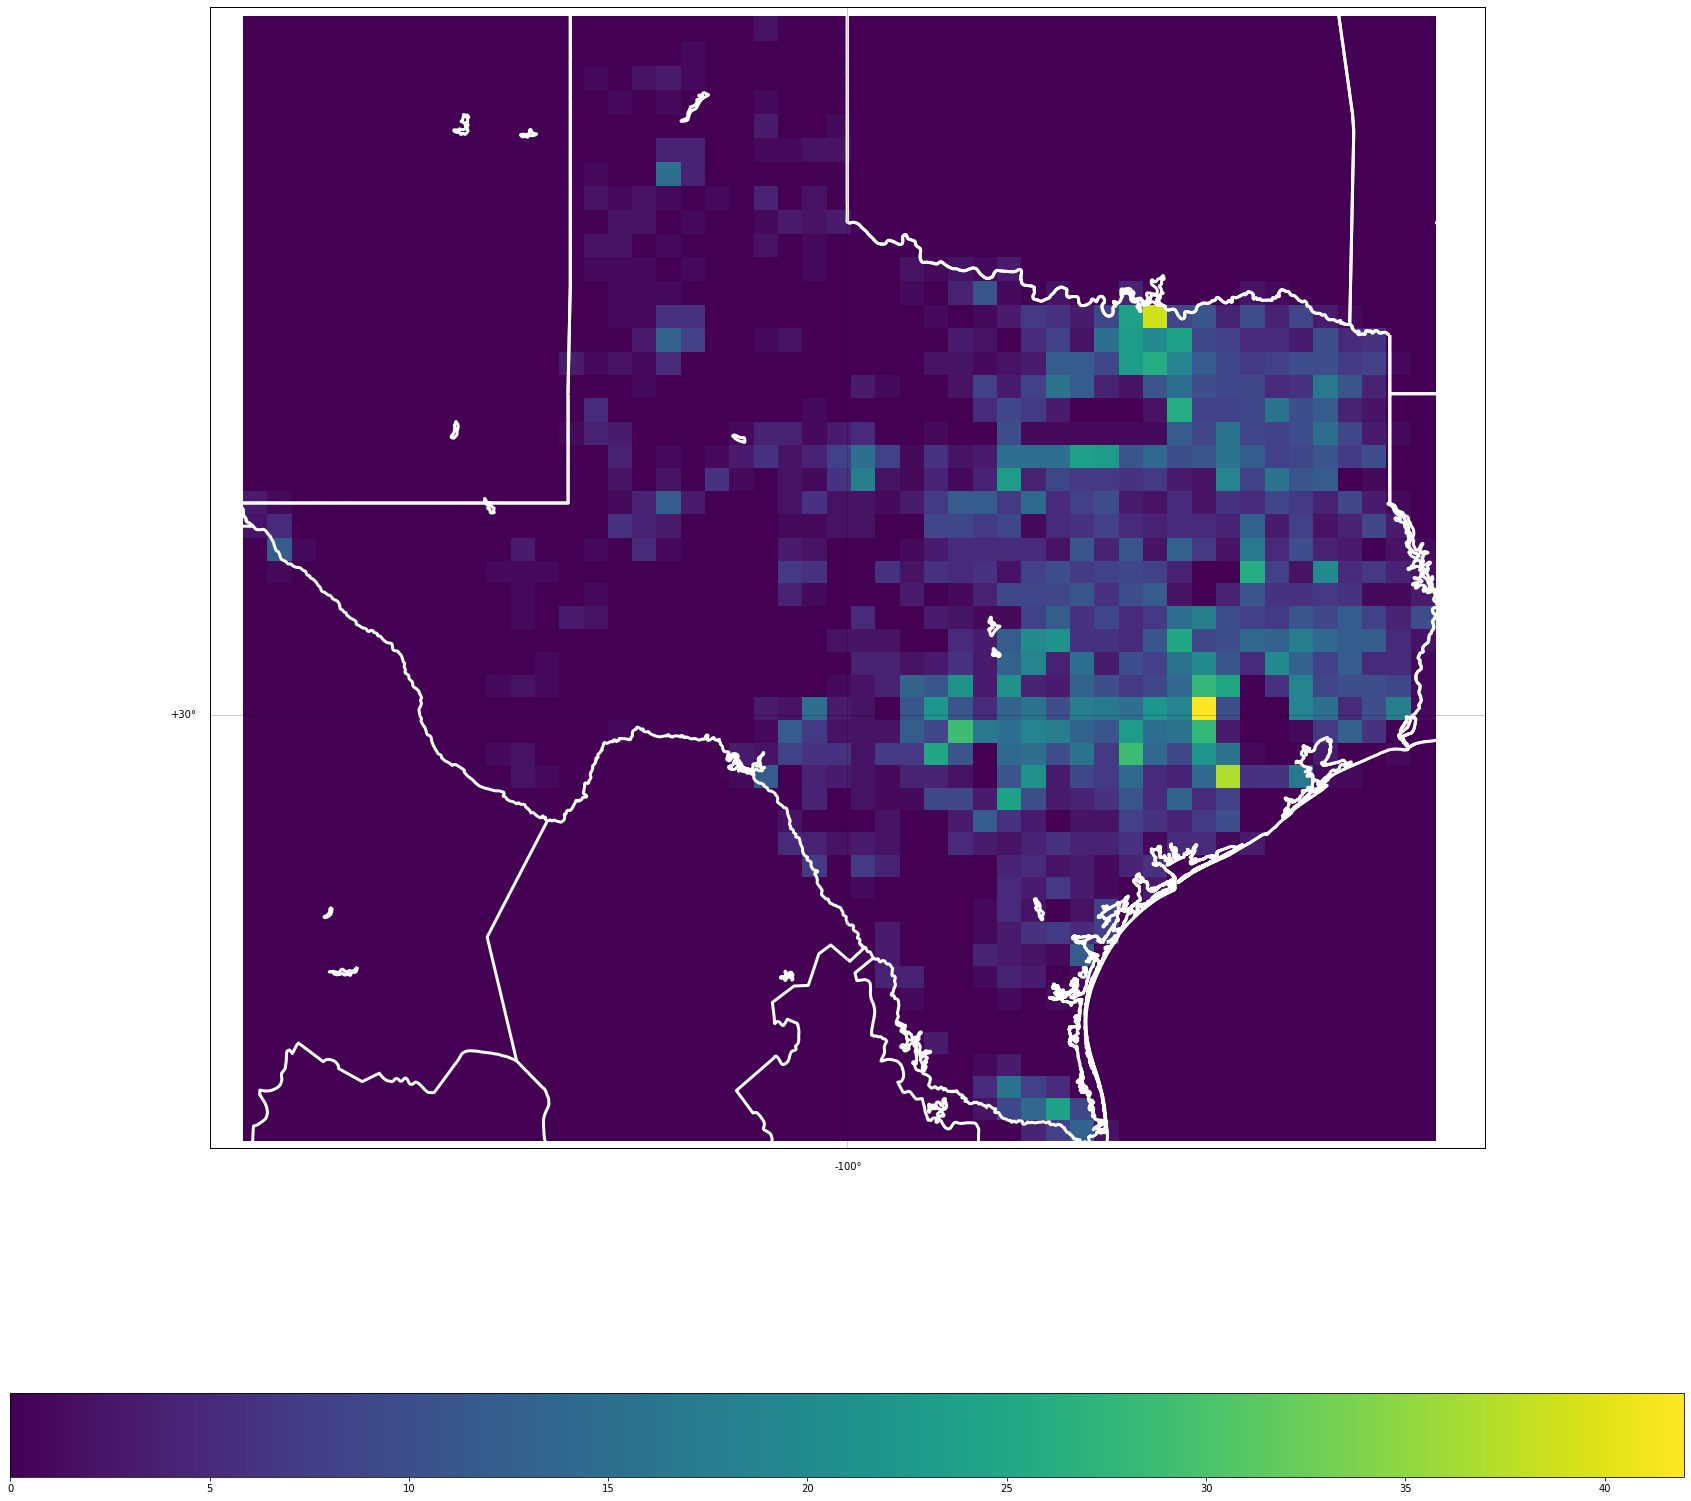

In [5]:
m = Basemap(resolution='f',projection='merc',                                        
            lon_0=160,                                                               
            llcrnrlat=25.8,                                                         
            urcrnrlat=36.5,                                                          
            llcrnrlon=-107.,                                                          
            urcrnrlon=-93,                                                         
            lat_ts=0.0) 

m.drawmapboundary(fill_color='white')                                                
m.drawcoastlines(color='white', linewidth=3)                                        
m.drawcountries(color='white', linewidth=3)  
m.drawstates(color='white', linewidth=3)
m.drawmeridians(np.arange(0, 360, 20),                                               
                labels=[0,0,0,1],                                                    
                color='black',                                                       
                dashes=[1,0],                                                        
                labelstyle='+/-',                                                    
                linewidth=0.2)         
m.drawparallels(np.arange(-90, 90, 10),                                              
                labels=[1,0,0,0],                                                    
                color='black',                                                       
                dashes=[1,0],                                                        
                labelstyle='+/-',                                                    
                linewidth=0.2) 
lons=data.long_centroid
lats=data.lat_centroid
lon_bins = np.linspace(lons.min(), lons.max(), 50)
lat_bins = np.linspace(lats.min(), lats.max(), 50)
# We create a 2d histogram for the frequency of listings
density, _, _ = np.histogram2d(lats, lons, [lat_bins, lon_bins])
# Turn the lon/lat bins into 2 dimensional arrays ready 
# for conversion into projected coordinates
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# Convert our values into map coordinates and plot on basemap

xs, ys = m(lon_bins_2d, lat_bins_2d)

plt.pcolormesh(xs, ys, density)
plt.colorbar(orientation='horizontal')

plt.show()

### Map of Acres for Sale

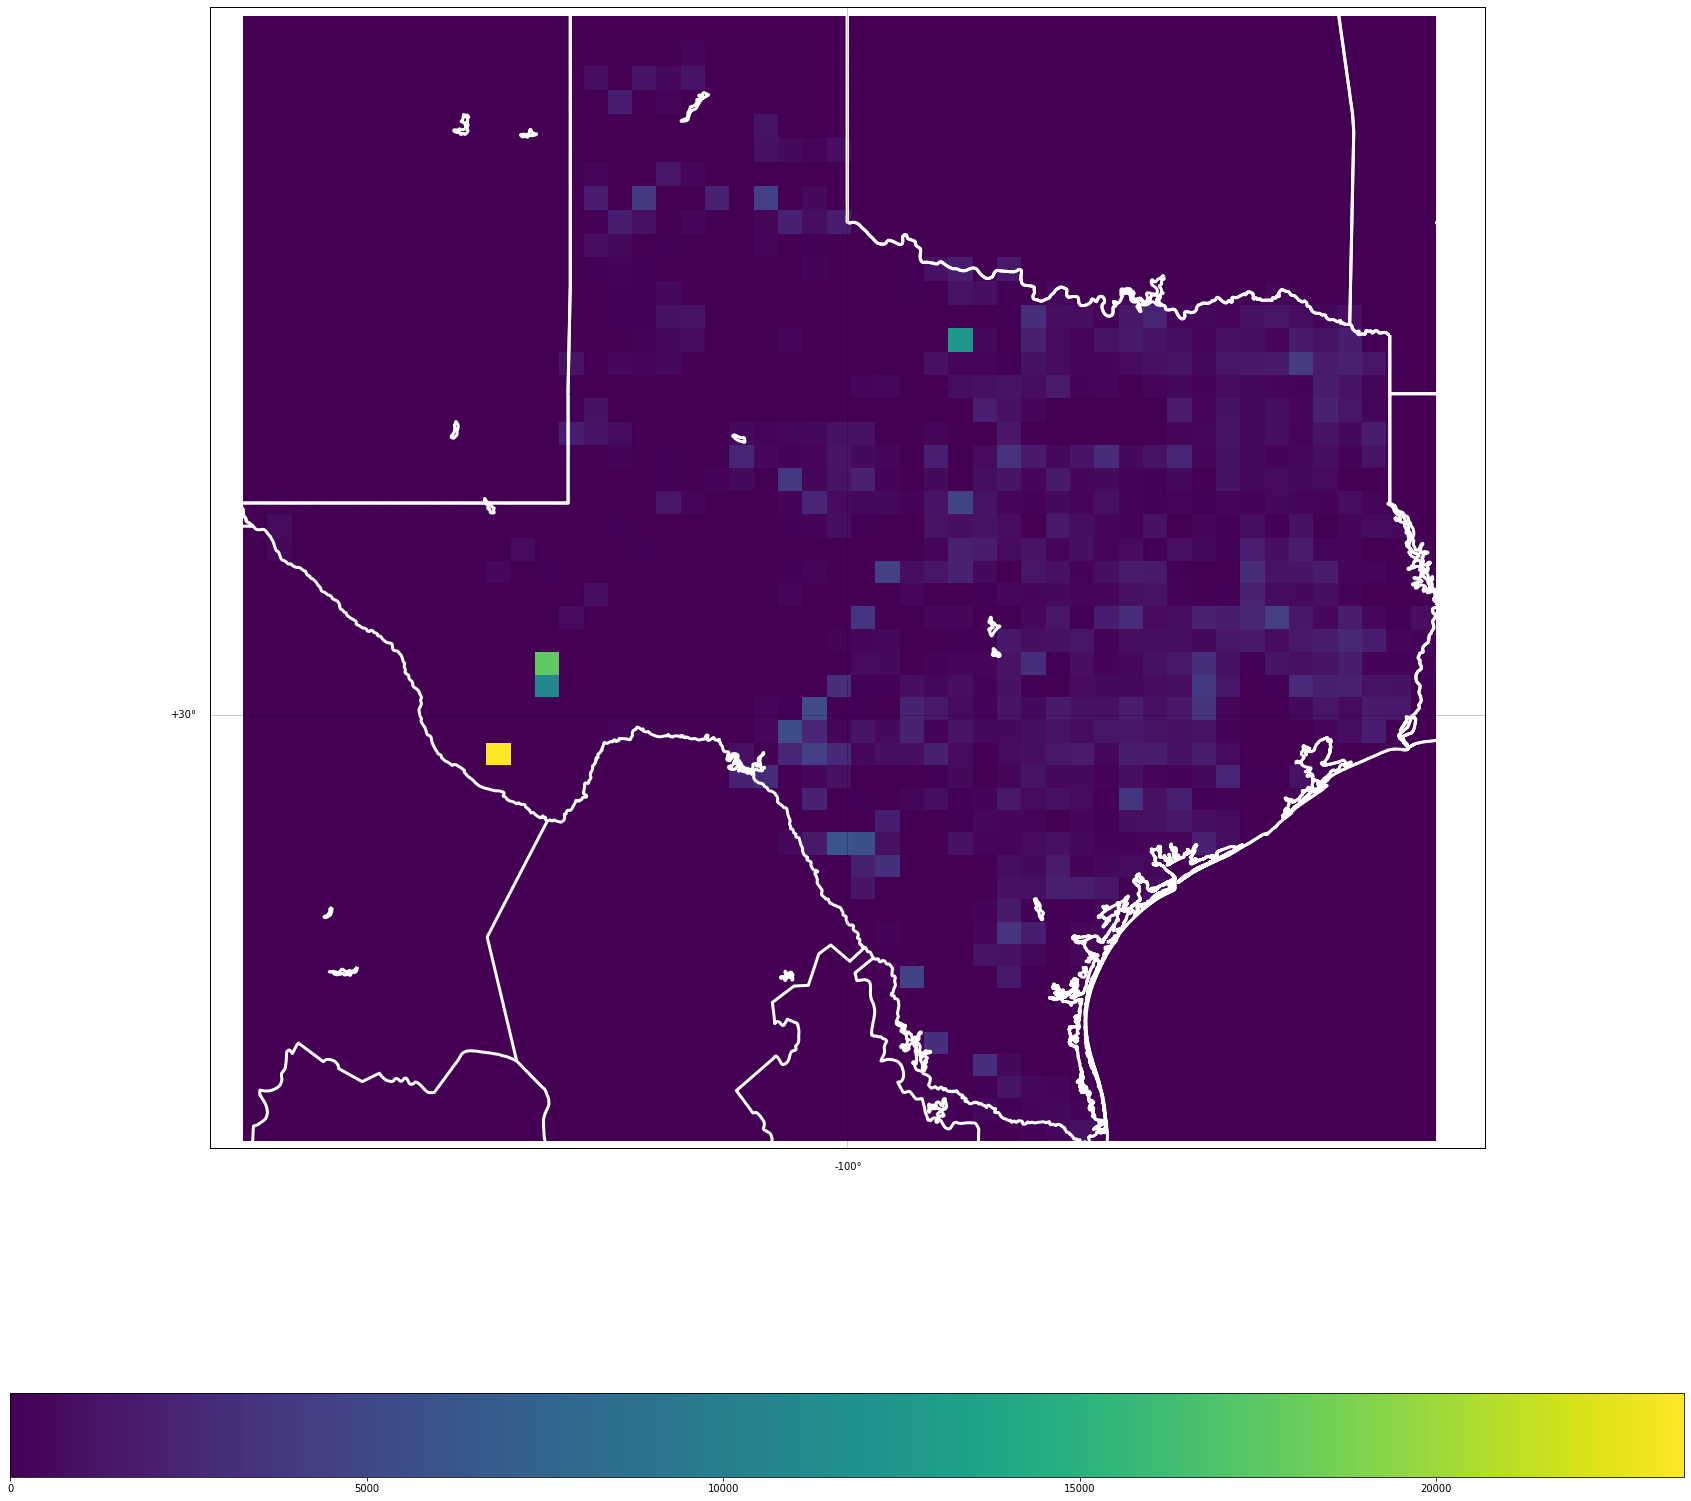

In [6]:
m = Basemap(resolution='f',projection='merc',                                        
            lon_0=160,                                                               
            llcrnrlat=25.8,                                                         
            urcrnrlat=36.5,                                                          
            llcrnrlon=-107.,                                                          
            urcrnrlon=-93,                                                         
            lat_ts=0.0) 

m.drawmapboundary(fill_color='white')                                                
m.drawcoastlines(color='white', linewidth=3)                                        
m.drawcountries(color='white', linewidth=3)  
m.drawstates(color='white', linewidth=3)
m.drawmeridians(np.arange(0, 360, 20),                                               
                labels=[0,0,0,1],                                                    
                color='black',                                                       
                dashes=[1,0],                                                        
                labelstyle='+/-',                                                    
                linewidth=0.2)         
m.drawparallels(np.arange(-90, 90, 10),                                              
                labels=[1,0,0,0],                                                    
                color='black',                                                       
                dashes=[1,0],                                                        
                labelstyle='+/-',                                                    
                linewidth=0.2) 
lons=data.long_centroid
lats=data.lat_centroid
lon_bins = np.linspace(lons.min(), lons.max(), 50)
lat_bins = np.linspace(lats.min(), lats.max(), 50)

density=get_total_in_range(data,'acres',lat_bins, lon_bins)

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)


xs, ys = m(lon_bins_2d, lat_bins_2d)

plt.pcolormesh(xs, ys, density)
plt.colorbar(orientation='horizontal')

plt.show()

### Map of Average Price per Acre

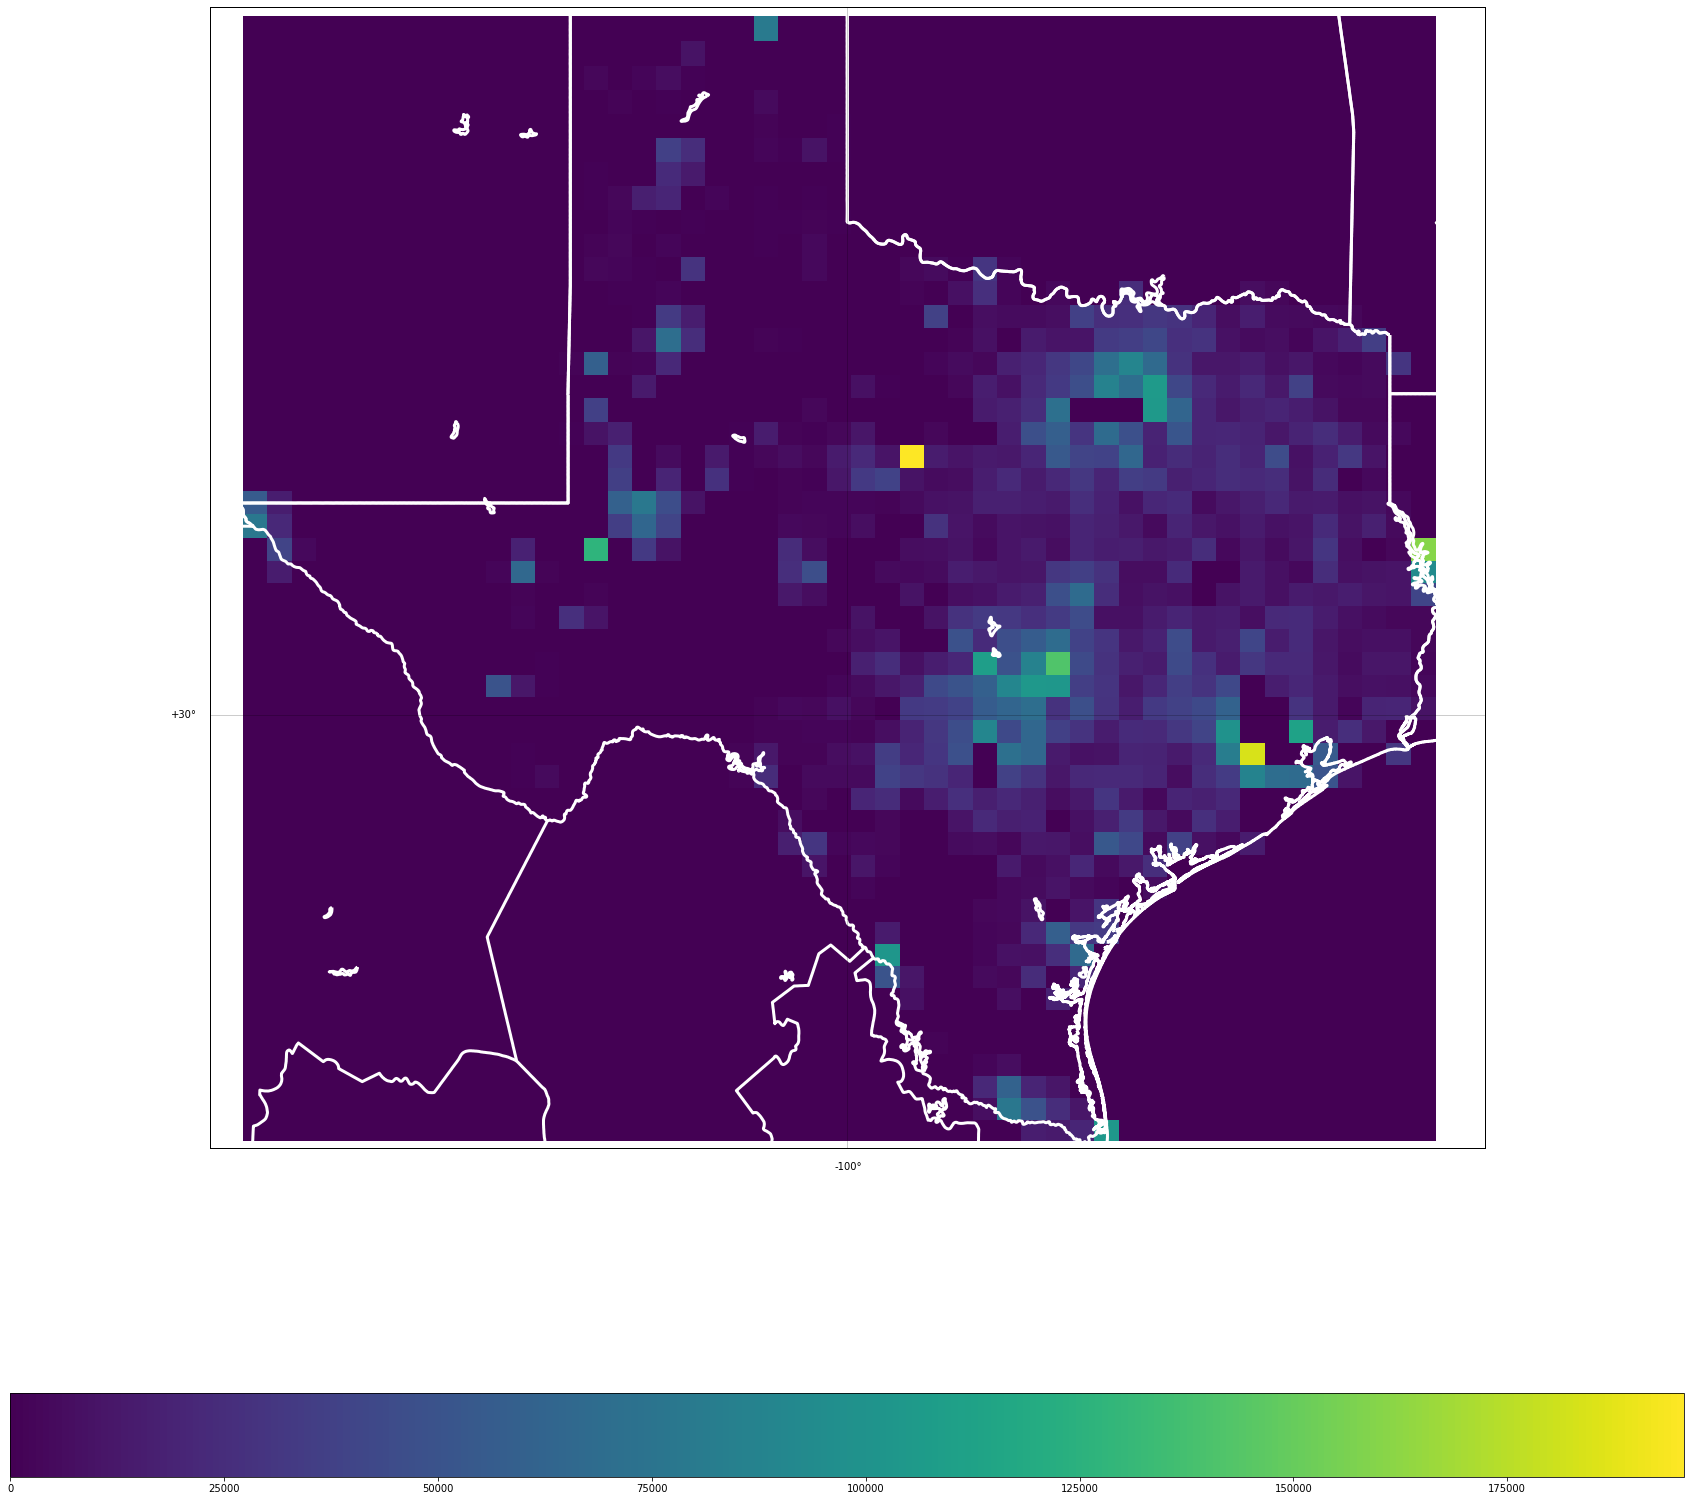

In [7]:
m = Basemap(resolution='f',projection='merc',                                        
            lon_0=160,                                                               
            llcrnrlat=25.8,                                                         
            urcrnrlat=36.5,                                                          
            llcrnrlon=-107.,                                                          
            urcrnrlon=-93,                                                         
            lat_ts=0.0) 

m.drawmapboundary(fill_color='white')                                                
m.drawcoastlines(color='white', linewidth=3)                                        
m.drawcountries(color='white', linewidth=3)  
m.drawstates(color='white', linewidth=3)
m.drawmeridians(np.arange(0, 360, 20),                                               
                labels=[0,0,0,1],                                                    
                color='black',                                                       
                dashes=[1,0],                                                        
                labelstyle='+/-',                                                    
                linewidth=0.2)         
m.drawparallels(np.arange(-90, 90, 10),                                              
                labels=[1,0,0,0],                                                    
                color='black',                                                       
                dashes=[1,0],                                                        
                labelstyle='+/-',                                                    
                linewidth=0.2) 
lons=data.long_centroid
lats=data.lat_centroid
lon_bins = np.linspace(lons.min(), lons.max(), 50)
lat_bins = np.linspace(lats.min(), lats.max(), 50)

density=get_total_in_range(data,'ppa',lat_bins, lon_bins, average=True)

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)


xs, ys = m(lon_bins_2d, lat_bins_2d)

plt.pcolormesh(xs, ys, density)
plt.colorbar(orientation='horizontal')

plt.show()

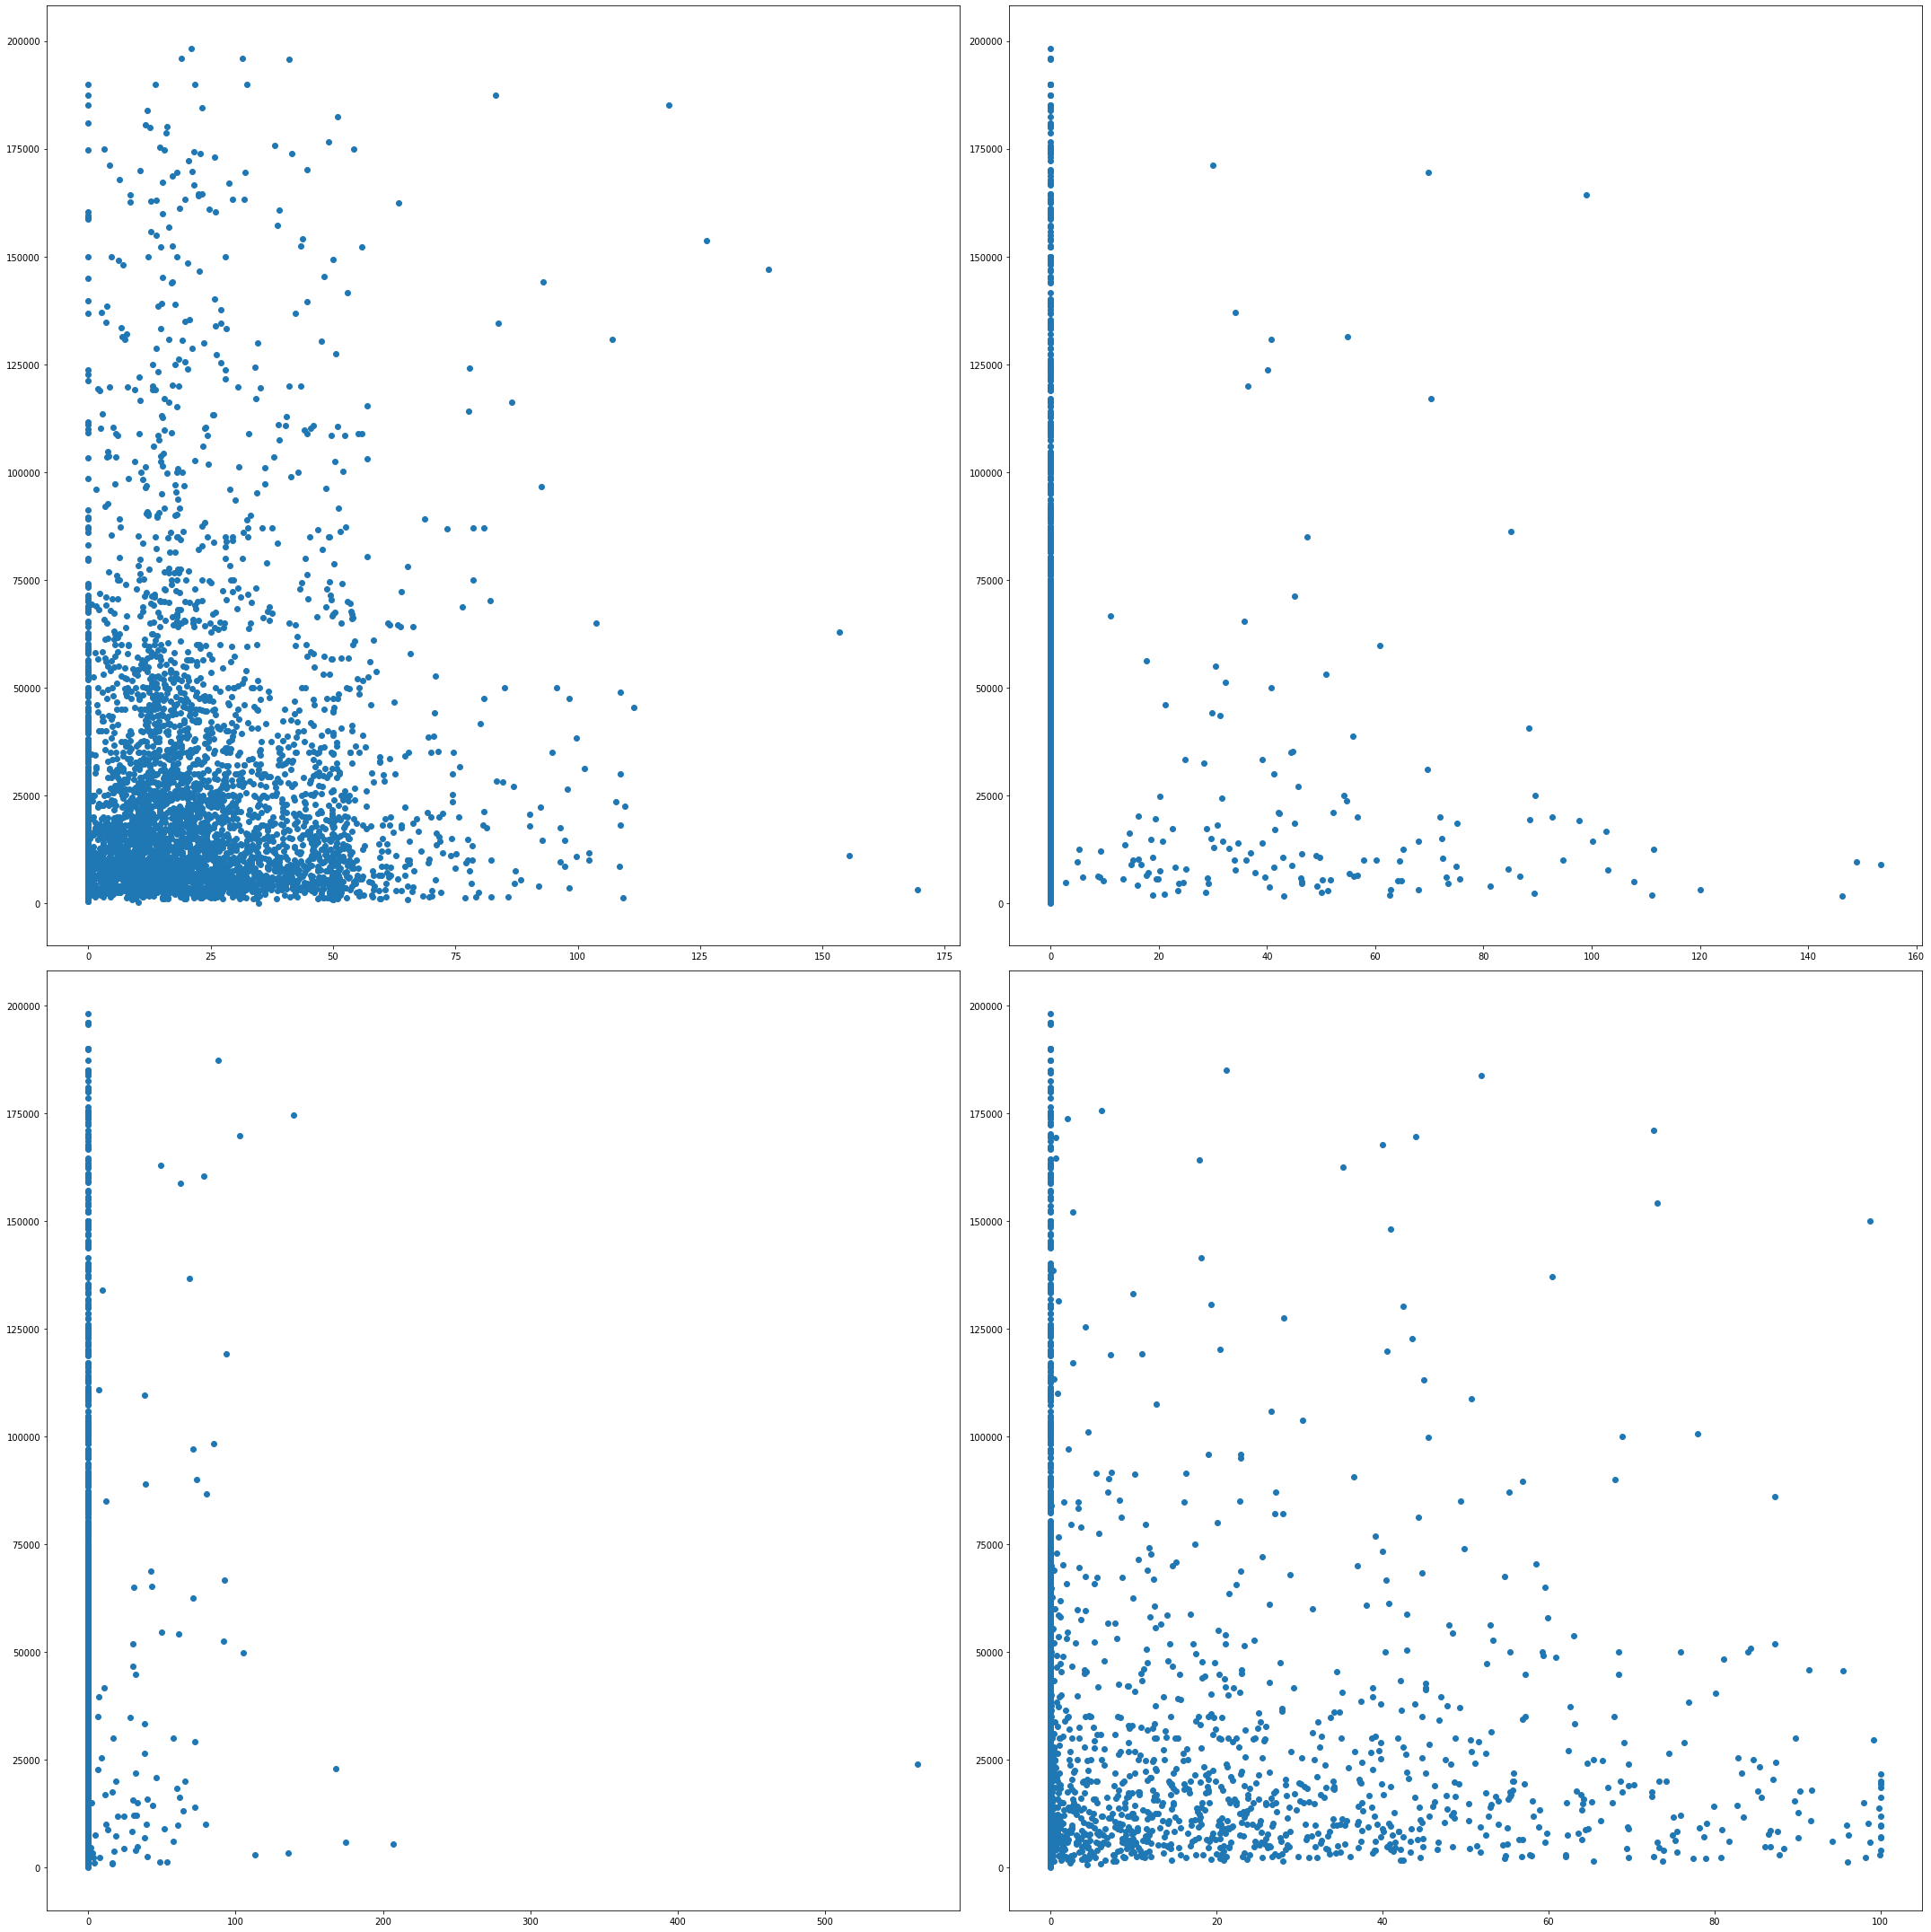

In [8]:
scatter_feats = ['road_gis_percent', 'river_percent', 'lake_percent', 'flood_per']
fig = plt.figure(1)
for i in range(1, len(scatter_feats)+1):
    fig.add_subplot(2, 2, i)
    plt.scatter(data[scatter_feats[i-1]], data['ppa'])

plt.tight_layout()
plt.show()

## Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))
feats=['long_centroid', 'lat_centroid', 'road_gis_percent', 'flood_per', 'river_percent', 'lake_percent','improved']
data[feats]=scaler.fit_transform(data[feats])
train_data, test_data = train_test_split(data, test_size=0.1, random_state=43)

## K-Nearest Neighbors

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

grid_params={
    'n_neighbors':np.arange(6, 24, 3),
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}
gs_nn = GridSearchCV(KNeighborsRegressor(), grid_params, verbose=0, cv=LeaveOneOut(), n_jobs=-1, scoring='neg_mean_squared_error')

X_train = train_data[['long_centroid', 'lat_centroid']]
y_train=train_data['ppa']
gs_nn.fit(X_train, y_train)
gt=test_data['price']
# Our output variable is price per acre so we need to multiply by acres to get the price
pred=gs_nn.predict(test_data[['long_centroid', 'lat_centroid']])*test_data['acres']
get_scores(gt, pred)

Mean Absolute Error (MAE): 1637910.6912358203
Mean Squared Error (MSE): 34550967182753.406
Root Mean Squared Error (RMSE): 5878007.075765851
Mean Absolute Percentage Error (MAPE): 127.08


## K-Nearest Neighbors -- with GIS

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

grid_params={
    'n_neighbors':np.arange(6, 24, 3),
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}
gs_nn = GridSearchCV(KNeighborsRegressor(), grid_params, verbose=0, cv=LeaveOneOut(), n_jobs=-1, scoring='neg_mean_squared_error')

X_train = train_data[feats]
y_train=train_data['ppa']
gs_nn.fit(X_train, y_train)
gt=test_data['price']
# Our output variable is price per acre so we need to multiply by acres to get the price
pred=gs_nn.predict(test_data[feats])*test_data['acres']
get_scores(gt, pred)

Mean Absolute Error (MAE): 1739150.36968229
Mean Squared Error (MSE): 20160941075256.637
Root Mean Squared Error (RMSE): 4490093.65996486
Mean Absolute Percentage Error (MAPE): 145.52


## Random Forest Regressor -- no GIS

In [12]:
from sklearn.ensemble import RandomForestRegressor

grid_params={
    'n_estimators':[100],
    'min_samples_split':[2, 3, 4],
    'max_features': ['auto', 'log2', 'sqrt', None],
    'bootstrap':[True, False]
}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=0), grid_params, verbose=0, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')

X_train = train_data[['long_centroid', 'lat_centroid', 'acres']]
y_train=train_data['price']
gs_rf.fit(X_train, y_train)

gt=test_data['price']
pred=gs_rf.predict(test_data[['long_centroid', 'lat_centroid', 'acres']])
get_scores(gt, pred)

Mean Absolute Error (MAE): 613160.9053578946
Mean Squared Error (MSE): 1130892082143.8118
Root Mean Squared Error (RMSE): 1063434.0986369639
Mean Absolute Percentage Error (MAPE): 77.3


## Random Forest Regressor -- with GIS

In [13]:
from sklearn.ensemble import RandomForestRegressor

grid_params={
    'n_estimators':[100],
    'min_samples_split':[2, 3, 4],
    'max_features': ['auto', 'log2', 'sqrt', None],
    'bootstrap':[True, False]
}
gs_rf_gis = GridSearchCV(RandomForestRegressor(random_state=0), grid_params, verbose=0, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')

X_train = train_data[feats+['acres']]
y_train=train_data['price']
gs_rf_gis.fit(X_train, y_train)

gt=test_data['price']
pred=gs_rf_gis.predict(test_data[feats+['acres']])
get_scores(gt, pred)

Mean Absolute Error (MAE): 608650.1168064502
Mean Squared Error (MSE): 853479328781.3651
Root Mean Squared Error (RMSE): 923839.4496780082
Mean Absolute Percentage Error (MAPE): 88.49
